# Ice Ocean Interactions

Initated: 13 December 2021 (JDL); Python 3
Last updated: 29 May 2023 (JDL)

For consideration of possible ice ocean interactions below ocean world ice shells. See Lawrence et al., 2023 (submitted to JGR, June 2023)

In [4]:
if 'google.colab' in str(get_ipython()):
  print('Running on Google CoLab, limited to matplotlib inline (non-interactive) plotting...\n')
  # install modules not included by default in google collab
  !pip install gsw
  !pip install cmocean
  # stuck with 2D plots for now in google colab
  %matplotlib inline
else:
  print('using matplotlib notebook plotting...\n')
  # required for interactive 3D plots, but does not work in google colab backend
  # %matplotlib notebook  # would ideally use this for the 3D plots, but causes other display issues
  %matplotlib inline



import gsw; print('gsw version:', gsw.__version__)
import cmocean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import plotly.graph_objects as go

using matplotlib notebook plotting...

gsw version: 3.4.0


In [5]:
# set save path for figures
path = '/Users/justinlawrence/Dropbox (Personal)/Papers and Manuscripts/Europa IceOcean Paper/Figures/' 

# set plotting label sizes
plt.rcParams['font.family'] = 'DejaVu Sans'  # stand in for Helvetica
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14

## Define some variables

Start with some assumptions. 

In [6]:
# constants
# g is surface gravitational acceleration (m s-2)
# ice density is typical for meteoric ice (kg m-3)

# dimensions bounded from Vance et al., 2018, Čadek et al., 2021, Wolfenbarger et al., 2022,
# []_range is: [name, x_SA_min, x_SA_max, km_min (draft), km_max (draft), fill_color]

# earth (equatorial, at sea level)
earth_g = gsw.grav(lat=90, p=0)
# europa
europa_g = 1.315
europa_bulk_shell_density = 917
europa_range = ['Europa', 5, 35, 2.5, 30, 'gray'] 
# enceladus
enceladus_g = 0.113
enceladus_bulk_shell_density = 917
enceladus_range = ['Enceladus', 2, 20, 5, 50, 'white']
# ganymede
ganymede_g = 1.428
ganymede_bulk_shell_density = 917
ganymede_range = ['Ganymede', 5, 35, 30, 130, 'gray']
# titan
titan_g = 1.352
titan_bulk_shell_density = 917
titan_range = ['Titan', .5, 39.5, 20, 100, 'white']

# and a few arrays to cover the parameter space of interest
n = 1000
P_array = np.linspace(0,6000,n)  # pressure (dbar)
SA_array = np.linspace(.2,40,n)  # absolute salinity (g/kg)
CT_array = np.linspace(-6,0,n)  # conservative temperature (°C)

# meshgrids for contour plots
X_SA, Y_P = np.meshgrid(SA_array, P_array)  
X_SA, Y_CT = np.meshgrid(SA_array, CT_array)  

# and ranges for ocean world salinities and ice thicknesses (Rignot et al. 2013)
# SA, CT, dbar (x, y, z coords for data)
FRL = [np.nan, np.nan, 2100]  # Filchner-Ronne(Rignot et al. 2013)
KGL = [34.78, -2.25, 515]  # Kamb GL (Lawrence et al. 2023)
BGL = [34.93, -1.90, 1800]  # Byrd Glacier GL; estimated pressure and HSSW properties
AGL = [34.93, -1.90, 2400]  # Amery GL (Galton-Fenzi et al. 2017; Rignot et al. 2013)
WGL = [34.73, -2.30, 665]  # Whillans GL (Begeman 2018)
SGL = [.3, 0, 3700]  # subglacial lakes, e.g. Vostok (Siegert et al. 2001; Jansen et al. 2010)

In [7]:
# functions to make a second y axis for equivalent ice shell thickness in below plots
def dbar_to_km(dbars, g, ice_density=917):
  # for an assumed bulk ice density and constant value for g
  # h (m) = pressure (pa) / (rho (kg/m3) * g (m/s2))
  # multiply by 1e4 to convert dbar to Pa; divide by 1e3 to convert from m to km
  shell_thick_km = ((dbars*1e4)/(ice_density*g))/1e3 
  return shell_thick_km

def km_to_dbar(km, g, ice_density=917):
  # for an assumed bulk ice density and constant value for g
  # pressure (pa) = rho (kg/m3) * g (m/s2) * h (m)
  # divide by 1e4 to convert Pa to dbar; multiple by 1e3 to convert from km to m
  pressure_dbar = (ice_density*g*km*1e3)/1e4
  return pressure_dbar

def convert_ax_dbar_to_km(first_axes, second_axes, body):
    # calls dbar_to_km conversion 
    ymin, ymax = first_axes.get_ylim()
    if body == 'Europa': 
        g = europa_g
        ice_density = europa_bulk_shell_density
    if body == 'Ganymede': 
        g = ganymede_g
        ice_density = ganymede_bulk_shell_density
    if body == 'Enceladus': 
        g = enceladus_g
        ice_density = enceladus_bulk_shell_density
    if body == 'Titan': 
        g = titan_g
        ice_density = titan_bulk_shell_density
        
    # and set the axes limits
    second_axes.set_ylim(dbar_to_km(ymin, g=g, ice_density=ice_density), 
                         dbar_to_km(ymax, g=g, ice_density=ice_density))

def add_oceanworld_patch(ax, body, x_SA_min, x_SA_max, shell_km_min, shell_km_max, fill_color='black', alpha=0.5, linewidth=1):
    # calls km_to_dbar conversion
    if body == 'Europa': 
        g = europa_g
        ice_density = europa_bulk_shell_density
    if body == 'Ganymede': 
        g = ganymede_g
        ice_density = ganymede_bulk_shell_density
    if body == 'Enceladus': 
        g = enceladus_g
        ice_density = enceladus_bulk_shell_density
    if body == 'Titan': 
        g = titan_g
        ice_density = titan_bulk_shell_density
        
    # convert km shell thickness to pressure (dbar) for each world (assuming 917 kg/m3 ice density)
    y_dbar_min = km_to_dbar(km=shell_km_min, g=g, ice_density=ice_density)
    y_dbar_max = km_to_dbar(km=shell_km_max, g=g, ice_density=ice_density)
    
    # add a labeled rectangular patch for tbe body of interest
    oceanworld_patch = patches.Rectangle((x_SA_min, y_dbar_min), x_SA_max-x_SA_min, y_dbar_max-y_dbar_min, linewidth=linewidth, linestyle='--', 
                                        edgecolor='black', facecolor=fill_color, alpha=alpha)
    ax.add_patch(oceanworld_patch)
    ax.annotate(body, (x_SA_min+.5, y_dbar_min+200), fontsize=14)
        
    print(f'added {body}, shell thickness ranging from {shell_km_min} km ({y_dbar_min} dbar) to {shell_km_max} km ({y_dbar_max} dbar)')


### Compare freezing points below ice shelves and ice shells:

/Users/justinlawrence/opt/anaconda3/envs/icefin/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


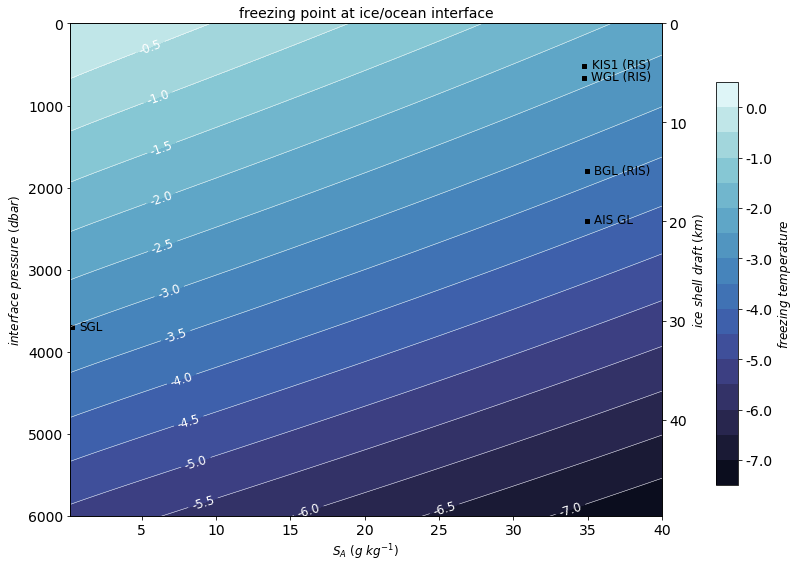

In [9]:
# make the figure
fig1, (ax1) = plt.subplots(1, 1, figsize=(10, 8))
plt.gca().invert_yaxis()

# plot the FP contour
levels=17
FPs = gsw.CT_freezing(SA=X_SA, p=Y_P, saturation_fraction=0)
contour = ax1.contourf(X_SA, Y_P, FPs, cmap='cmo.ice', levels=levels)
cbaxes = fig1.add_axes([1, 0.15, 0.03, 0.7])  # colorbar axis to leave room for second y axis
cbar = plt.colorbar(contour, format='%1.1f', ax=ax1, cax=cbaxes)
cbar.set_label(label='$freezing\ temperature$', size=12)

# add the rest of the contour lines
clines = ax1.contour(X_SA, Y_P, FPs, linestyles='-', colors='white', alpha=1, linewidths=.5, levels=levels)
ax1.clabel(clines, clines.levels[::], fontsize=12, inline=True, fmt='%1.1f', inline_spacing=3, colors='white')

# add points for terrestrial examples
# Ross Ice Shelf Locations (Discovery Deep, KIS1, Amery)
for point, name in zip([KGL, WGL, BGL, AGL, SGL], ['KIS1 (RIS)', 'WGL (RIS)', 'BGL (RIS)', 'AIS GL', 'SGL']):
  ax1.scatter(point[0], point[2], label=name, s=20, marker='s', color='black')
  ax1.annotate(name, (point[0]+.5, point[2]+30), fontsize=12)

# add some axis labels
ax1.set_xlabel('$S_A\ (g\ kg^{-1})$', fontsize=12)
ax1.set_ylabel('$interface\ pressure\ (dbar)$', fontsize=12)
ax1.set_title(r'freezing point at ice/ocean interface', fontsize=14);
ax1.set_xlim(.2, X_SA.max())

# add right side y axis, for ice shell thickness equivalent
ax2 = ax1.twinx()
# add ice shell thickness equivalent to second y axes
convert_ax_dbar_to_km(ax1, ax2, body='Europa')
ax2.set_ylabel('$ice\ shell\ draft\ (km)$', fontsize=12)
plt.tight_layout()

## Consider the pressure dependence of the freezing point... pressure dependence

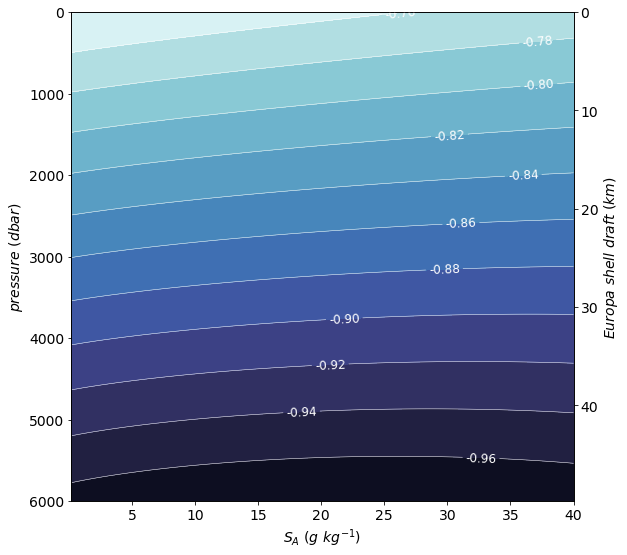

In [10]:
# calc slope of FP line for a bunch of different salinities and pressures
P_step = 1  # dbar

X_upper, Y_upper = np.meshgrid(SA_array, P_array)
X_lower, Y_lower = np.meshgrid(SA_array, P_array+P_step)

FP_upper = gsw.CT_freezing(SA=X_upper, p=Y_upper, saturation_fraction=0)  # FP at pressure = p
FP_lower = gsw.CT_freezing(SA=X_lower, p=Y_lower, saturation_fraction=0)  # FP at pressure = p+1
FP_diff = (FP_lower - FP_upper) *1e3  # [change in FP * 1e3] --> to convert K to mK

# make the plot
fig, (ax1) = plt.subplots(1, 1, figsize=(9, 9))
plt.gca().invert_yaxis()

# plot the FP slope contour
levels=np.arange(-.98, -0.72, 0.02)
FP_slope_contour = ax1.contourf(X_upper, Y_upper, FP_diff, cmap='cmo.ice', levels=levels)
# cbaxes = fig.add_axes([1, 0.15, 0.03, 0.7])  # colorbar axis to leave room for second y axis
# fig.colorbar(FP_slope_contour, label=r'$freezing\ point\ depression\ (mK\ dbar^{-1})$', format='%1.2f', ax=ax1)
# add the contour lines
clines = ax1.contour(X_upper, Y_upper, FP_diff, linestyles='-', colors='white', alpha=1, linewidths=.5, levels=levels)
ax1.clabel(clines, clines.levels[::], fontsize=12, inline=True, fmt='%1.2f', inline_spacing=3, colors='white')

# labels
ax1.set_xlabel('$S_A\ (g\ kg^{-1})$')
ax1.set_ylabel('$pressure\ (dbar)$')

# add right side y axis, for ice shell thickness equivalent
ax2 = ax1.twinx()
convert_ax_dbar_to_km(ax1, ax2, body='Europa')
ax2.set_ylabel('$Europa\ shell\ draft\ (km)$')

# save it out
plt.savefig(path+'FP_P_dependence.pdf', format='pdf', bbox_inches = "tight")

**Figure** This plot demonstrates, for a range of seawater (NaCl-dominanted, or thallasohaline composition) salinities (0-40 $g\ kg^{-1}$) and pressures (dbar), the change in freezing point at constant salinity across different pressure varies by less than 1 mK.

Here, for the interface below a 20 km Europan shell (~2500 dbar), we consider -0.85 $mK\ dbar^{-1}$ (the freezing point cools, or decreases, by 0.85 mK per dbar pressure increase) as a mean value for the pressure dependence of the freezing point (for thallasohaline oceans - same value as in Melosh 2004 and just a little higher than value in Vance 2007, S8.1 - who also note that this value is largely independent of composition for NaCl or MgSO4.)

Since we're curious about how pressure affects thermal driving, how does the magnitude of the change in the freezing point with pressure compare to the adiabatic lapse rate?

## Freezing Point Depression & Adiabatic Lapse Rate 

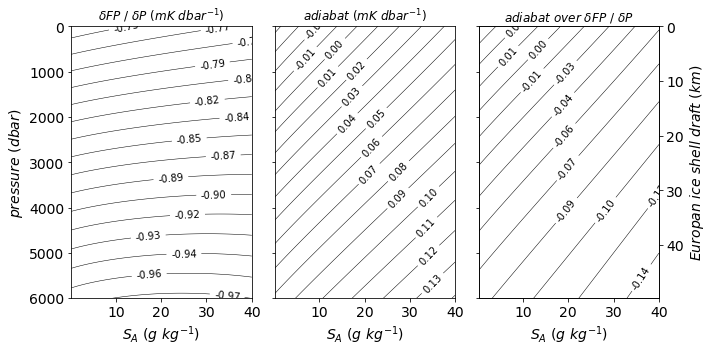

In [12]:
# make a plot of the ALR / FP pressure dependence, to show always < 1
ALR_mk_dbar = gsw.adiabatic_lapse_rate_from_CT(SA=X_SA, CT=0, p=Y_P)*1e4*1e3  # output is K/Pa, converting to mK (*1e3) per dbar (*1e4)
ALR_over_FP_diff = ALR_mk_dbar/FP_diff

# initiate the plot
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
plt.gca().invert_yaxis()

# plot the contours
FP_diff_con = ax1.contour(X_SA, Y_P, FP_diff, linestyles='-', colors='black', alpha=1, linewidths=0.5, levels=20)
ax1.clabel(FP_diff_con, fontsize=10, inline=True, fmt='%1.2f', inline_spacing=3)

ALR_mk_dbar_con = ax2.contour(X_SA, Y_P, ALR_mk_dbar, linestyles='-', colors='black', alpha=1, linewidths=0.5, levels=20)
ax2.clabel(ALR_mk_dbar_con, fontsize=10, inline=True, fmt='%1.2f', inline_spacing=3)

ALR_over_FP_diff_con = ax3.contour(X_SA, Y_P, ALR_over_FP_diff, linestyles='-', colors='black', alpha=1, linewidths=0.5, levels=16)
ax3.clabel(ALR_over_FP_diff_con, fontsize=10, inline=True, fmt='%1.2f', inline_spacing=3)

# label the plot
ax1.set_title(r'$\delta FP\ /\ \delta P\ (mK\ dbar^{-1})$')
ax2.set_title(r'$adiabat\ (mK\ dbar^{-1})$')
ax3.set_title(r'$adiabat\ over\ \delta FP\ /\ \delta P$')
for ax in [ax1, ax2, ax3]: ax.set_xlabel('$S_A\ (g\ kg^{-1})$')
for ax in [ax1]: ax.set_ylabel('$pressure\ (dbar)$')

# add right side y axis, for ice shell thickness equivalent
ax4 = ax3.twinx()
convert_ax_dbar_to_km(ax3, ax4, body='Europa')
ax4.set_ylabel('$Europan\ ice\ shell\ draft\ (km)$')
plt.tight_layout()

# save the figure out
plt.savefig(path+'FP_depression_and_ALR.pdf', format='pdf', bbox_inches = "tight")


**Figure** Three panel plot comparing freezing point pressure dependence and the adiabatic lapse rate (ALR) for the bounded pressure and salinity ranges, showing that the ALR magnitude is generally an order less than the pressure depression of the freezing point. Panel A also highlights that freezing point depression for these ranges is minimally dependent on salinity.

For a pressure of 2500 dbar and SA of 35 g/kg, the freezing point would be -3.9366°C.
Initial thermal driving is prescribed at 0.043 K such that
the ocean temperature at the mean ice base is -3.8936°C.


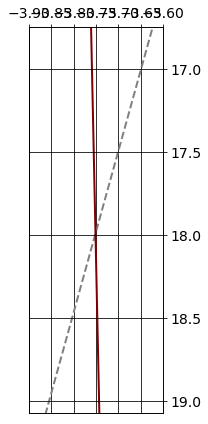

In [13]:
# vertical profile of slope of adiabat relative to slope of the freezing point

def plot_vert_europa_profile(SA=35, CT=-2, P=2500, thermal_driving=0.1, FP_depression = -0.85):    
    """
    This function will generate a vertical profile that compares the slope of the freezing point to the adiabat, 
    which we can use to generate some hypothetical upper ocean profiles for the different topography cases,
    and then consider how vertical pressure change affects thermal driving.
    
    We stick with an SA of 35, a CT of -2 (for calculating a constant adiabat value), and a pressure of 2500 dbar as an approx range for the ocean below
    a 20 km ice shell, but we just use these values to calculate the adiabat and the freezing point.
    
    We can then prescribe some nominal thermal driving, perhaps on order +0.1°C, which is in predicted ranges for
    ocean temepratures and typical for cold cavity ice shelves on Earth. 
    
    Finally, we stick with the constant value for the freezing point slope of -0.85 mK/dbar.
    """
    
    # calculate some initial values
    surface_FP = gsw.CT_freezing(SA=SA, p=0, saturation_fraction=0)
    FP_depress = FP_depression*1e-3  # convert mK/dbar to K/dbar
    adiabat = gsw.adiabatic_lapse_rate_from_CT(SA=SA, CT=CT, p=P)*1e4  # output is K/Pa, converting to per dbar (*1e4)
    # prescribe an initial upper mixed layer temp as the freezing temp + a bit of sensible heat
    FP = gsw.CT_freezing(SA=SA, p=P, saturation_fraction=0)
    theoretical_ocean_temp = FP+thermal_driving  
    # and calc the lines to plot
    FP_line = (FP_depress*P_array)+surface_FP
    temp_profile = (adiabat*P_array)+theoretical_ocean_temp  # shift the temp profile by the initial thermal driving
    
    # initiate the plot
    fig1, (ax1) = plt.subplots(1, 1, figsize=(3, 6))
    plt.gca().invert_yaxis()

    # add lines for freezing point and adiabat
    ax1.plot(FP_line, P_array, color='grey', linestyle='--', linewidth=2)
    ax1.plot(temp_profile, P_array, color='maroon', linewidth=2)    
    
    # labels and limits
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top') 
    ax1.set_ylabel('$ice\ shell\ basal\ pressure\ (dbar)$', fontsize=12)
    ax1.yaxis.set_visible(False)
    ax1.set_ylim(2300, 2020)

    
    # add right side y axis, for ice shell thickness equivalent
    ax2 = ax1.twinx()

    # automatically update ylim of ax2 when ylim of ax1 changes.
    ax1.grid(visible=True, which='major', axis='x', color='black')
    ax2.grid(visible=True, which='major', axis='y', color='black')

    ax1.xaxis.set_ticks(np.arange(-10, 0, .05))
    ax1.set_xlim(-3.9, -3.6)

    convert_ax_dbar_to_km(ax1, ax2, body='Europa')
    plt.tight_layout()
    
    print(f'For a pressure of {P} dbar and SA of {SA} g/kg, the freezing point would be {np.around(FP,4)}°C.')
    print(f'Initial thermal driving is prescribed at {thermal_driving} K such that')
    print(f'the ocean temperature at the mean ice base is {np.around(theoretical_ocean_temp,4)}°C.')

plot_vert_europa_profile(thermal_driving=0.043)

plt.savefig(path+'FP_profile.png', format='png', bbox_inches = "tight", dpi=300)


### What is the freezing point depression per dbar and m at Europa?

In [14]:
# calc the change in FP per m, assuming constant gravity and water density
const_density = 1000  # kg m-3
fp_press_dependence = -0.85  # mK dbar-1, taken as mean from plot above
dbar_to_m_conversion = (const_density*europa_g*1)/10000  # *1 for pressure change over 1 m elevation change
print(f'One dbar of pressure change at Europa is equivalent to {dbar_to_m_conversion} m,')
fp_press_dependence = fp_press_dependence*dbar_to_m_conversion
print(f'so the freezing point decreases by {np.around(fp_press_dependence, 5)} mK per meter,') 
print('essentially scaled by gravity as we hold density constant.')

One dbar of pressure change at Europa is equivalent to 0.1315 m,
so the freezing point decreases by -0.11178 mK per meter,
essentially scaled by gravity as we hold density constant.


In [11]:
# and just demonstrating the relationship for KIS1, as we observed it
print('KIS Analogy, if we knew only the salinity and elevation differential -->')
# approx values for the KIS crevasse system
FP_icebase_KIS = gsw.CT_freezing(SA=34.77, p=510, saturation_fraction=0)

# How many degrees C change in the freezing point does this topographic disequlibria represent?
FP_delta_KIS = FP_icebase_KIS - gsw.CT_freezing(SA=34.77, p=470, saturation_fraction=0)

print('calculated upper layer temperature (*C):', np.around(FP_icebase_KIS-FP_delta_KIS,3))
print('observed upper layer temperature (*C): -2.250')

KIS Analogy, if we knew only the salinity and elevation differential -->
calculated upper layer temperature (*C): -2.257
observed upper layer temperature (*C): -2.250


## Ocean Property Contour Plots (NaCl / Thalassohaline Composition)
Let's now consider pressure, salinity, and temperature effects on other seawater properties.

### Consider the 'practical' temperature of maximum density:
Which is the temperature of max density when it's greater than the freezing point, and otherwise the freezing point --> 

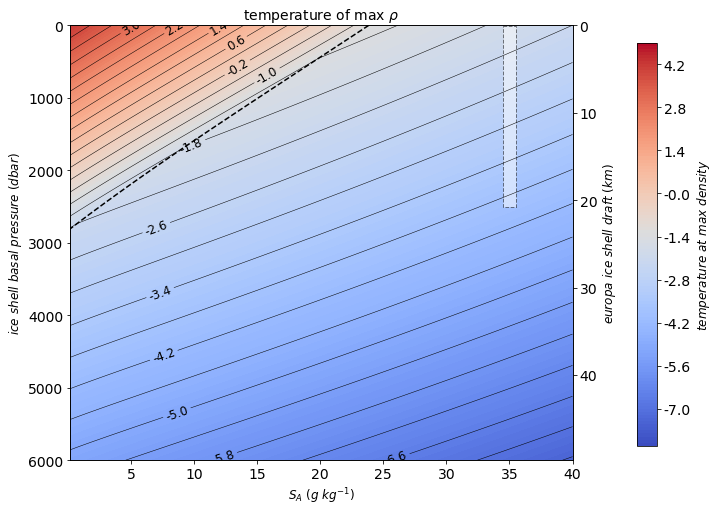

In [21]:
# subtract the freezing point from the temperature of maximum in situ density
# want to know when temp of max density is colder or warmer than FP
FPs = gsw.CT_freezing(SA=X_SA, p=Y_P, saturation_fraction=0)
CT_maxdens = gsw.CT_maxdensity(SA=X_SA, p=Y_P)
differenced = CT_maxdens - FPs 
# but just take the warmer value of the two
TMD_FP_array = np.maximum(CT_maxdens, FPs)

# make the figure
fig1, (ax1) = plt.subplots(1, 1, figsize=(9, 8))
plt.gca().invert_yaxis()

# plot the difference contour
difference_levels = np.arange(-8.2,5,.1)
divnorm=colors.TwoSlopeNorm(vmin=difference_levels.min(), vcenter=-1.25, vmax=difference_levels.max())  # off centering the colorbar
difference = ax1.contourf(X_SA, Y_P, TMD_FP_array, levels=difference_levels, cmap='coolwarm', norm=divnorm)
cbaxes = fig1.add_axes([1, 0.15, 0.03, 0.7])  # colorbar axis to leave room for second y axis
cbar = plt.colorbar(difference, format='%1.1f', ax=ax1, cax=cbaxes)
cbar.set_label(label='$temperature\ at\ max\ density$', size=12)

# highlight the equivalence point between temp of max density and freezing point (~24 ppt at 0 dbar)
zero_line = ax1.contour(X_SA, Y_P, differenced, linestyles='--', colors='black', alpha=1, linewidths=1.5, levels=[0])

# add the rest of the contour lines
difference_lines = ax1.contour(X_SA, Y_P, TMD_FP_array, linestyles='-', colors='black', alpha=1, linewidths=.5, levels=difference_levels[::4])
ax1.clabel(difference_lines, difference_lines.levels[::2], fontsize=12, inline=True, fmt='%1.1f', inline_spacing=3)

# Create a Rectangle patch
sub_shelf_range = patches.Rectangle((34.5, 10), 1, 2500, linewidth=1, linestyle='--', edgecolor='black', facecolor='white', alpha=0.5)
ax1.add_patch(sub_shelf_range)

# add some axis labels
ax1.set_xlabel('$S_A\ (g\ kg^{-1})$', fontsize=12)
ax1.set_ylabel('$ice\ shell\ basal\ pressure\ (dbar)$', fontsize=12)
ax1.set_title(r'temperature of max $\rho$', fontsize=14);

# add right side y axis, for ice shell thickness equivalent
ax2 = ax1.twinx()
ax2.set_ylabel('$europa\ ice\ shell\ draft\ (km)$', fontsize=12)
# automatically update ylim of ax2 when ylim of ax1 changes.
convert_ax_dbar_to_km(ax1, ax2, body='Europa')

plt.savefig(path+'t_of_max_d.pdf', format='pdf', bbox_inches = "tight")



**Figure** This plot shows the functional temperature of maximum density - substituting the freezing point temperature when the temp of max density is below the freezing point. Dashed white line demarcates the regime shift from densest at a temperature above the freezing point (lacustrine dynamics) to densest below, or functionally at, the freezing point (marine dynamics), where the former experiences full overturning at the temperature of max density before freezing occurs. White shaded box is approximate range of conditinos below terrestrial ice shelves. See also Talley (2011) Table 3.4.

For regimes where waters are densest when warmer than freezing point (red shades below ~2800 dbar or 28 MPa or < 24 g/kg seawater comp), ice pumping may actually operate slightly more effectively where buoyancy is driven by both cooling and freshening upon GMW input from melting.

However, there is an inflection point - if the ice and ocean are both fresh there is no salt flux and it is only the temperature change that drives the circulation (See preprint by Kang et al., 2022). So, for a fresh ocean above a certain pressure such that downwelling occurs upon cooling with the addition of melt water, ice pumping will not occur.

**This plot catches us up to Melosh et al., 2004 Figure 2.**
> *Thus, if the ice shell is more than about 23 km thick, or the ocean as salty as the Earth's oceans (34.4 per mil on average), then convection proceeds as described above and no thermal contradiction occurs.* 
> *Data by Chen et al. (1980), while limited to temperatures above 0 °C, indicate that, at 1 atm pressure, the salinities needed to decrease the temperature of maximum density from 3.98 to 0 °C are 18, 26, 19, and 34 per mil for the salts NaCl, MgCl2, Na2SO4, and MgSO4, respectively, suggesting that the results quoted above for the better-studied seawater solutions are reasonably typical.* See Vance 2007 Figure 8, after Melosh 2004 Figure 2, as well.

But, this plot may not completely describe the regimes where we expect ice pumping - for example at the end member of a fresh, high pressure ocean cool melt water will downwell instead of upwelling. We also know that at Earth's ocean salinity though, the salt flux is sufficient to overcome the temperature change. This leaves the question then of 'is there some critical salinity which, for different pressure regimes, ice pumping 'turns on' and the the freshening upon melt addition overcomes the thermal buoyancy loss upon cooling?' 

### Plot of alpha, beta, and ∆T/∆S for different ocean S,P end members
Sort out exactly which P,T,S regimes we expect ice pumping. For example - a totally fresh ocean, such that there is no salinity to freshen, below a certain pressure will have a positive thermal expansion coefficient and sink when cooled instead of rising. Need a better plot to show this. 

The slope of the Gade Line, for different hypothetical end member ocean salinites, can be multiplied with α∆T/β∆S to see if there are any cases, in addition to freshwater, where it evaluates to ≥1. 

Essentially, is there some pressure-dependent salinity value for which ice pumping 'turns on'?

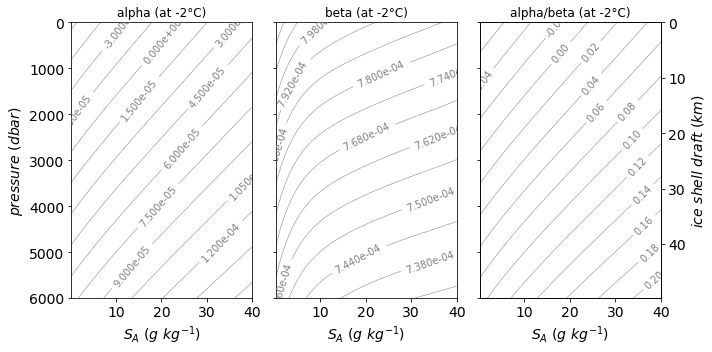

In [22]:
# calc alpha and beta for the regime of interest
# start at -2°C (to keep things in 2 dimensions)
temp_ocean = FPs  # -2; using the (SA,P)-dependent FP as the assumption for ocean temp 
# thermal expansion coefficient with respect to CT
alphas = gsw.alpha(SA=X_SA, CT=temp_ocean, p=Y_P)  # (1/K)
# saline contraction coefficient at constant CT
betas = gsw.beta(SA=X_SA, CT=temp_ocean, p=Y_P)  # (kg/g)
# alpha over beta
alpha_over_beta = gsw.alpha_on_beta(SA=X_SA, CT=temp_ocean, p=Y_P)

# plot them
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10, 5))
plt.gca().invert_yaxis()
alpha_con = ax1.contour(X_SA, Y_P, alphas, linestyles='-', colors='grey', alpha=1, linewidths=0.5, levels=15)
ax1.clabel(alpha_con, fontsize=10, inline=True, fmt='%.3e', inline_spacing=3)
beta_con = ax2.contour(X_SA, Y_P, betas, linestyles='-', colors='grey', alpha=1, linewidths=0.5, levels=15)
ax2.clabel(beta_con, fontsize=10, inline=True, fmt='%.3e', inline_spacing=3)
alpha_beta_con = ax3.contour(X_SA, Y_P, alpha_over_beta, linestyles='-', colors='grey', alpha=1, linewidths=0.5, levels=15)
ax3.clabel(alpha_beta_con, fontsize=10, inline=True, fmt='%1.2f', inline_spacing=3)
for ax in [ax1, ax2, ax3]: ax.set_xlabel('$S_A\ (g\ kg^{-1})$')
for ax in [ax1]: ax.set_ylabel('$pressure\ (dbar)$')
ax1.set_title('alpha (at -2°C)')
ax2.set_title('beta (at -2°C)')
ax3.set_title('alpha/beta (at -2°C)')

ax4 = ax3.twinx()
convert_ax_dbar_to_km(ax3, ax4, body='Europa')
ax4.set_ylabel('$ice\ shell\ draft\ (km)$')
plt.tight_layout()

**Figure** The ratio of $\alpha$ over $\beta$ for the range considered is always <1, indicating that salt flux is more important than a temperature change in determine water density. This is why melt water generated below ice shelves is buoyant - even though the thermal expansion coefficient is positive and the cooling upon meltwater input increases the density of the mixture, the freshening effect is stronger and the net density decreases.

However, we know that at the freshwater limit where there is no salt in the system to offset the density increase upon cooling, meltwater will downwell. At what ocean salinity does the freshening effect from melt input overcome the cooling effect, essentially 'turning on' ice pumping which requires the melt mixture to be buoyant and upwell?

We can use the Gade relationship to consider the (linear) ratio of temperature change to salinity change upon melting into ocean waters of different salinity, to see the where the magnitude of temp and salinity change.

In [23]:
@np.vectorize
def gade(CT_ocean, SA_ocean, p, L_f=334000):
    '''
    This function calculates the predicted conservative temperature of host waters mixing
    with ice melt. This assumes that latent heat transfer dominates over sensible during melting,
    and that the volume of resulting melt water is small. *_ocean represents the end member properties
    of the dominant water mass in contact with ice. Appropriate values for CT_ocean and SA_ocean
    should be selected depending on the sample location. Water that is a mixture of the ice melt
    and initial water mass will fall close to the line.

    :param CT_ocean: temperature of the ocean end member [CT; °C]
    :param SA_ocean: salinity of the ocean end member [SA; g/kg]
    :param SA: salinity of the sample water [SA; g/kg]
    :param p: pressure of the sample water [dbar]
    :param L_f: latent heat of fusion for ice [J/kg]
    :param c_p: specific heat of seawater [J/kg*K]
    :return: predicted conservative temperature upon mixing of these water masses [CT; °C]
    '''
    # first calculate salinity/temp/pressure dependent specific heat
    # http://www.teos-10.org/pubs/gsw/html/gsw_cp_t_exact.html
    # Heat capacity is the heat required to raise the temperature of an object
    # by 1°C. Specific heat is the energy required to raise the T of 1 g by 1°C.
    c_p = gsw.cp_t_exact(SA=SA_ocean, t=CT_ocean, p=p)  # J/(kg*K)

    # Note: the Gade calc is only linear for salinities near the ocean end member,
    # so have to calc the slope over that range.
    SA_linspace = np.linspace(SA_ocean - .1, SA_ocean + .1, 100)
    CT_gade = CT_ocean + (L_f / c_p) * (1 - (SA_ocean / SA_linspace))
    slope = (CT_gade.max() - CT_gade.min()) / (SA_linspace.max() - SA_linspace.min())  # rise / run
    # print('slope =', np.around(slope, 5), '°C/(g/kg)')
    # return CT_gade, slope, SA_linspace
    return slope

In [24]:
# Gade line slopes for the range of SA and P we are interested in
slopes = gade(CT_ocean=temp_ocean, SA_ocean=X_SA, p=Y_P)  # dT/dP
# thermal expansion coefficient with respect to CT
alphas = gsw.alpha(SA=X_SA, CT=temp_ocean, p=Y_P)  # (1/K)
# saline contraction coefficient at constant CT
betas = gsw.beta(SA=X_SA, CT=temp_ocean, p=Y_P)  # (kg/g)
# alpha over beta
alpha_over_beta = gsw.alpha_on_beta(SA=X_SA, CT=temp_ocean, p=Y_P)

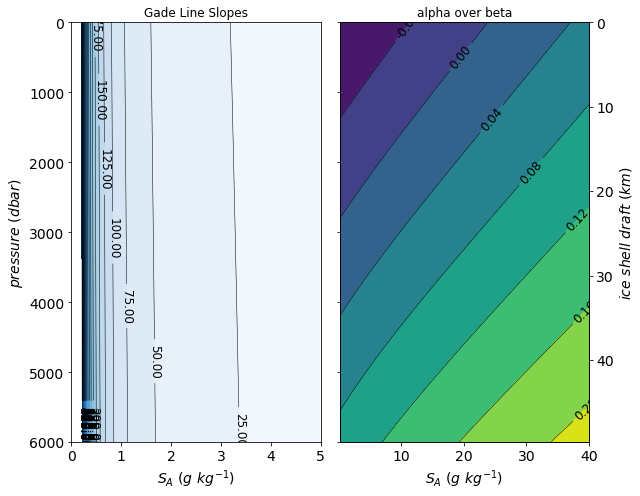

In [25]:
# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 7), sharey=True)
plt.gca().invert_yaxis()

# Gade slopes
levels = np.linspace(0, 500, 21)
slope_contour = ax1.contourf(X_SA, Y_P, slopes, cmap='Blues', levels=levels)
# ax1_cbaxes = fig.add_axes([1, 0.15, 0.03, 0.7])  # colorbar axis to leave room for second y axis
# ax1.colorbar(slope_contour, label=r'$Gade\ slope\ (dT dS)$', format='%1.2f', ax=ax1, cax=cbaxes)
clines = ax1.contour(X_SA, Y_P, slopes, linestyles='-', colors='black', alpha=1, linewidths=.5, levels=levels)
ax1.clabel(clines, fontsize=12, inline=True, fmt='%1.2f', inline_spacing=3)
ax1.set_title('Gade Line Slopes')
ax1.set_xlim(0,5)

# alpha/beta
contour = ax2.contourf(X_SA, Y_P, alpha_over_beta, cmap='viridis')
# ax2_cbaxes = fig.add_axes([.98, 0.15, 0.03, 0.7])  # colorbar axis to leave room for second y axis
# plt.colorbar(contour, label=r'$alpha\ over\ beta$', format='%1.2f', ax=ax2, cax=ax2_cbaxes)
ax2_clines = ax2.contour(X_SA, Y_P, alpha_over_beta, linestyles='-', colors='black', alpha=1, linewidths=.5)
ax2.clabel(ax2_clines, fontsize=12, inline=True, fmt='%1.2f', inline_spacing=3)
ax2.set_title('alpha over beta')

# labels
ax1.set_xlabel('$S_A\ (g\ kg^{-1})$')
ax2.set_xlabel('$S_A\ (g\ kg^{-1})$')
ax1.set_ylabel('$pressure\ (dbar)$')

# add right side y axis, for ice shell thickness equivalent
ax3 = ax2.twinx()
convert_ax_dbar_to_km(ax2, ax3, body='Europa')
ax3.set_ylabel('$ice\ shell\ draft\ (km)$')
plt.tight_layout()

Text(0, 0.5, '$ice\\ shell\\ draft\\ (km)$')

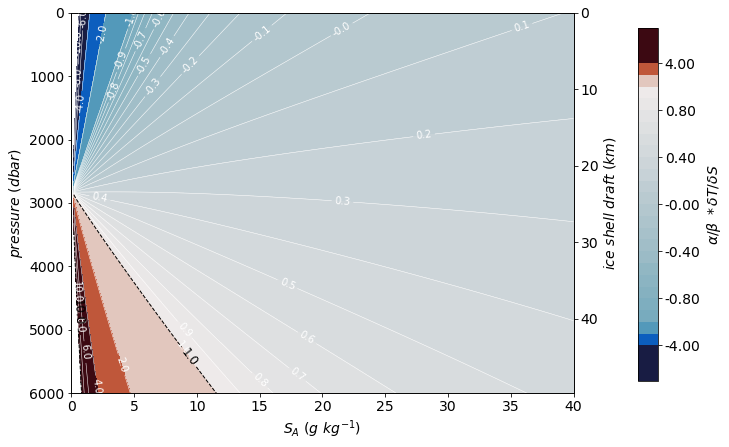

In [26]:
# now, multiply 
a_b_times_slopes = alpha_over_beta*slopes

fig, (ax1) = plt.subplots(1, 1, figsize=(9, 7))
plt.gca().invert_yaxis()

# plot the Gade slopes to see if ∆T*alpha/∆S*beta is ever greater than 1
levels = [-10, -8, -6, -4, -2, -1]+np.arange(-.9, 1, 0.1).tolist()+[1, 2, 4, 6, 8, 10]
divnorm=colors.TwoSlopeNorm(vmin=-5, vcenter=1.0, vmax=5)  # off centering the colorbar
slope_contour = ax1.contourf(X_SA, Y_P, a_b_times_slopes, cmap='cmo.balance', levels=levels, norm=divnorm)
ax1_cbaxes = fig.add_axes([1, 0.15, 0.03, 0.7])  # colorbar axis to leave room for second y axis
plt.colorbar(slope_contour, label=r'$\alpha/\beta\ * \delta T/ \delta S$', format='%1.2f', ax=ax1, cax=ax1_cbaxes)

# add background lines
clines = ax1.contour(X_SA, Y_P, a_b_times_slopes, linestyles='-', colors='white', alpha=1, linewidths=.5, levels=levels)
ax1.clabel(clines, fontsize=10, inline=True, fmt='%1.1f', inline_spacing=3)

unity_line = ax1.contour(X_SA, Y_P, a_b_times_slopes, linestyles='--', colors='black', alpha=1, linewidths=1, levels=[1, 10])
ax1.clabel(unity_line, fontsize=12, inline=True, fmt='%1.1f', inline_spacing=3, colors='black')

ax1.set_xlabel('$S_A\ (g\ kg^{-1})$')
ax1.set_ylabel('$pressure\ (dbar)$')

ax1.set_xlim(0,40)

# add right side y axis, for ice shell thickness equivalent
ax2 = ax1.twinx()
convert_ax_dbar_to_km(ax1, ax2, body='Europa')
ax2.set_ylabel('$ice\ shell\ draft\ (km)$')
# plt.tight_layout()

**Figure** This plot shows the salinity at which ice pumping 'turns off' at different pressures (ice/ocean interface depths for different shell thicknesses). Values greater than 1 (shaded red) indicate a ∆T great enough to overcome the ∆S in determining density, such that cool melt water will downwell instead of rising.

added Europa, shell thickness ranging from 2.5 km (301.46375 dbar) to 30 km (3617.565 dbar)
added Enceladus, shell thickness ranging from 5 km (51.8105 dbar) to 50 km (518.105 dbar)
added Ganymede, shell thickness ranging from 30 km (3928.428 dbar) to 130 km (17023.188 dbar)
added Titan, shell thickness ranging from 20 km (2479.568 dbar) to 100 km (12397.840000000002 dbar)


/Users/justinlawrence/opt/anaconda3/envs/icefin/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


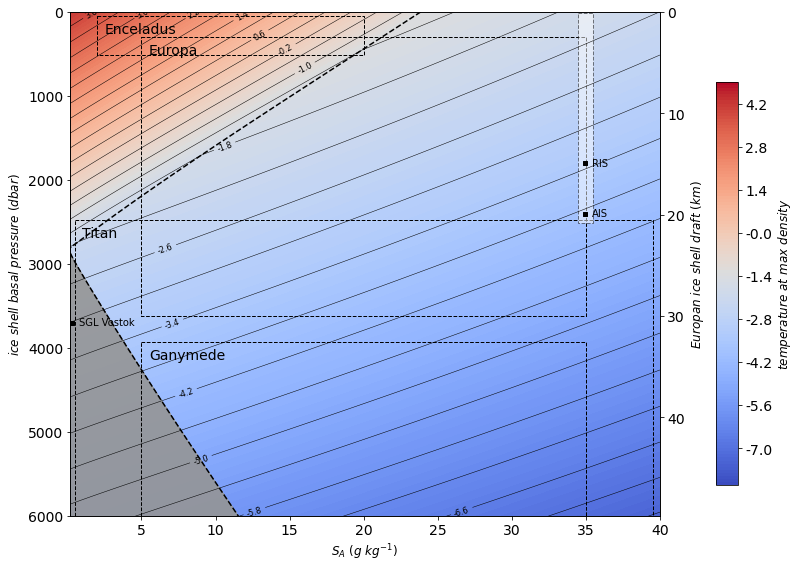

In [27]:
# logically, we just want the warmest number from either array - the CT of max dens
# when it's warmer than the FP, and otherwise just the FP when the CT of max dens is colder
# same as practical_tofmaxd = np.where(CT_maxdens>FPs, CT_maxdens, FPs)
practical_tofmaxd = np.maximum(CT_maxdens, FPs)

# Put it all together
cline_fsize = 8

# make the figure
fig1, (ax1) = plt.subplots(1, 1, figsize=(10, 8))
plt.gca().invert_yaxis()  # so pressure increases downward

# plot the difference contour
difference_levels = np.arange(-8.2,5,.1)
array = practical_tofmaxd
divnorm=colors.TwoSlopeNorm(vmin=difference_levels.min(), vcenter=-1.25, vmax=difference_levels.max())  # off centering the colorbar
difference = ax1.contourf(X_SA, Y_P, array, levels=difference_levels, cmap='coolwarm', norm=divnorm)
cbaxes = fig1.add_axes([1, 0.15, 0.03, 0.7])  # colorbar axis to leave room for second y axis
cbar = plt.colorbar(difference, format='%1.1f', ax=ax1, cax=cbaxes)
cbar.set_label(label='$temperature\ at\ max\ density$', size=12)
# highlight the equivalence point between temp of max density and freezing point (~24 ppt at 0 dbar)
zero_line = ax1.contour(X_SA, Y_P, differenced, linestyles='--', colors='black', alpha=1, linewidths=1.5, levels=[0])
# ax1.clabel(zero_line, fontsize=16, inline=True, fmt='%1.0f', inline_spacing=3, colors='white', levels=[0])
# add the rest of the contour lines
difference_lines = ax1.contour(X_SA, Y_P, array, linestyles='-', colors='black', alpha=1, linewidths=.5, levels=difference_levels[::4])
ax1.clabel(difference_lines, difference_lines.levels[::2], fontsize=cline_fsize, inline=True, fmt='%1.1f', inline_spacing=3)

# add no ice pumping regime from Gade slope * alpha/beta
a_b_times_slope_levels = [1, 1000]
a_b_times_slope = ax1.contourf(X_SA, Y_P, a_b_times_slopes, cmap='Greys', alpha=.9, levels=a_b_times_slope_levels)
# a_b_times_slope = ax1.contour(X_SA, Y_P, a_b_times_slopes, linestyles='-', colors='black', alpha=1, linewidths=0.5, levels=a_b_times_slope_levels)
unity_line = ax1.contour(X_SA, Y_P, a_b_times_slopes, linestyles='--', colors='black', alpha=1, linewidths=1.5, levels=[1])
# ax1.clabel(unity_line, fontsize=16, inline=True, fmt='%1.0f', inline_spacing=3, colors='white', levels=[1])

    
# add some axis labels
ax1.set_xlabel('$S_A\ (g\ kg^{-1})$', fontsize=12)
ax1.set_ylabel('$ice\ shell\ basal\ pressure\ (dbar)$', fontsize=12)
# ax1.set_title(r'temperature of max $\rho$', fontsize=14)
ax1.set_xlim(.2,40)
ax1.set_ylim(Y_P.max(), 0)

# add right side y axis, for ice shell thickness equivalent
ax2 = ax1.twinx()
ax2.set_ylabel('$Europan\ ice\ shell\ draft\ (km)$', fontsize=12)
# automatically update ylim of ax2 when ylim of ax1 changes.
convert_ax_dbar_to_km(ax1, ax2, body='Europa')

# save the figure out
plt.savefig(path+'ice_pump_domains_no_OW_overlay.png', format='png', bbox_inches = "tight", dpi=300)

# add patches for different worlds
patches_list = [europa_range, enceladus_range, ganymede_range, titan_range]
for patch_item in patches_list:
    add_oceanworld_patch(ax1, patch_item[0], patch_item[1], patch_item[2], patch_item[3], patch_item[4], fill_color='None', alpha=1)

    
# Create a Rectangle patch
sub_shelf_range = patches.Rectangle((34.5, 10), 1, 2500, linewidth=1, linestyle='--', edgecolor='black', facecolor='white', alpha=0.5)
ax1.add_patch(sub_shelf_range)

# add points for terrestrial oceans and subglacial lakes
for point, name in zip([BGL, AGL, SGL], ['RIS', 'AIS', 'SGL Vostok']):
  ax1.scatter(point[0], point[2], label=name, s=10, marker='s', color='black')
  ax1.annotate(name, (point[0]+.5, point[2]+30), fontsize=10)

    
plt.tight_layout()

# save the figure out
plt.savefig(path+'ice_pump_domains.pdf', format='pdf', bbox_inches = "tight", dpi=300)


**Figure 7.** Salinity and Pressure space for where we expect ice pumping to operate via combined temperature and salt flux upon melting.